This is my first dive into machine learning, the idea being to gain an understanding of the matrix operations involved in 

In [1]:
# Import box
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plot

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [2]:
#Setup box
# /!\ Reminder, COLUMN MAJOR!
#Supervised learning

debug = True

breastCancerDataset = load_breast_cancer()

m_total = len(breastCancerDataset.target)
y = breastCancerDataset.target.reshape(m_total, 1)
x = breastCancerDataset.data[:, np.r_[0:10]]
x = preprocessing.scale(x)

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.1)

xTrain = xTrain.T
xTest = xTest.T
yTrain = yTrain.T
yTest = yTest.T

nFeatures = xTrain.shape[0]
nNodes = nFeatures+2

if(debug):
    print("xTrain: ", xTrain.shape)
    print("nFeatures: ", nFeatures)
    print("nNodes: ", nNodes)

xTrain:  (10, 512)
nFeatures:  10
nNodes:  12


In [7]:
def initialise_parameters(nNodes, nFeatures):      # random weights for W & b -> must never intialise weights to 0
    
    # W size: (nNodes, nFeatures per testcase)
    
    w = np.random.rand(nNodes, nFeatures)       
    b = np.random.rand(nNodes, 1)
    return (w, b)

def LeakyReLU(Z, slope=0.05):  # Rectified Linear Unit function
    return np.maximum(slope*Z, Z)

def delta_LeakyReLU(Z, slope=0.05):
    Z[Z>0] = 1
    Z[Z<0] = slope  
    return Z
    
def Sigmoid(Z, factor=1):                # pretty much tanh(x) but not really
    return (1/(1+np.exp(-Z*factor)))

def delta_Sigmoid(Z, factor=1):
    return np.multiply(Z, 1-Z*factor)

def feed_forward_process(A, W, b):   # .T --> transpose
    return np.dot(W, A)+b

def feed_backward_process(X, Y, parameters, memory):
    m = Y.shape[1]        # number of examples

    W1, W2 = parameters["W1"], parameters["W2"]
    b1, b2 = parameters["b1"], parameters["b2"]
    A1, A2, Z1 = memory["A1"], memory["A2"], memory["Z1"]
    
    dZ2 = A2 - Y
        
    dW2 = 1/m*np.dot(dZ2,A1.T)
    db2 = 1/m*np.sum(dZ2, axis=1, keepdims=True) 
    
    dZ1 = np.multiply(np.dot(W2.T, dZ2),  delta_LeakyReLU(Z1))
    dW1 = 1/m*np.dot(dZ1, X.T)
    db1 = 1/m*np.sum(dZ1, axis=1, keepdims=True)

    gradients = {
        "dW1" : dW1,
        "db1" : db1,
        "dW2" : dW2,
        "db2" : db2
    }
    
    return gradients
    
def update_parameters(gradients, parameters, learningRate):
    parameters["W1"] = parameters["W1"]- gradients["dW1"]*learningRate
    parameters["b1"] = parameters["b1"]- gradients["db1"]*learningRate
    parameters["W2"] = parameters["W2"]- gradients["dW2"]*learningRate
    parameters["b2"] = parameters["b2"]- gradients["db2"]*learningRate
    return parameters

def cost_compute(Y, A):               # cost function to be found in the coursera lectures
    sample = np.multiply(Y, np.log(A)) + np.multiply((1-Y), np.log(1-A))
    sample = np.sum(sample)
    return -sample/Y.shape[1]


In [8]:
def Model(X, Y, xTest, yTest, nNodes, nFeatures, nIterations=10000, debug=False, learningRate=0.01):
    nInputs = Y.shape[0]

    W1 = initialise_parameters(nNodes, nFeatures)[0]
    b1 = initialise_parameters(nNodes, nFeatures)[1]
                
    parameters = {}
    parameters["W1"], parameters["b1"] = W1, b1
    parameters["W2"], parameters["b2"] = initialise_parameters(1, nNodes)
    parameters["b2"] = np.zeros((1,1))
    
    Cost = []
    Accuracy = []
    
    for i in range(0, nIterations):
        Z1 = feed_forward_process(X, parameters["W1"], parameters["b1"])
        A1 = LeakyReLU(Z1)
        Z2 = feed_forward_process(A1, parameters["W2"], parameters["b2"])
        A2 = Sigmoid(Z2)
        cost = cost_compute(Y, A2)
        Cost.append(cost)       # plot it
        
        memory = {
            "A1" : A1,
            "A2" : A2,
            "Z1" : Z1
        }
        
        gradients = feed_backward_process(X, Y, parameters, memory)
        parameters = update_parameters(gradients, parameters, learningRate)
    
        if(debug and i % 1000 == 0):
            print("iteration: ", i , "  cost: ", cost)
        
        predictions = prediction(xTest, parameters)
        accuracy = float((np.dot(yTest, predictions.T) + np.dot(1 - yTest, 1 - predictions.T))/ float(yTest.size) * 100)
        Accuracy.append(accuracy)
        
    print("Model is ready!")
    
    plot.figure(1)
    plot.plot(Cost)
    plot.ylabel('The Cost Function ($)')
    
    plot.figure(2)
    plot.plot(Accuracy)
    plot.ylabel('Accuracy (%)')
    
    plot.show()
    
    return parameters

In [9]:
def prediction(xTest, parameters):
    Z1 = feed_forward_process(xTest, parameters["W1"], parameters["b1"])
    A1 = LeakyReLU(Z1)
    Z2 = feed_forward_process(A1, parameters["W2"], parameters["b2"])
    A2 = Sigmoid(Z2)
    prediction = np.round(A2)
    return prediction
    

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in log


iteration:  0   cost:  inf
iteration:  1000   cost:  0.463991786118
iteration:  2000   cost:  0.393092960933
iteration:  3000   cost:  0.345955647939
Model is ready!


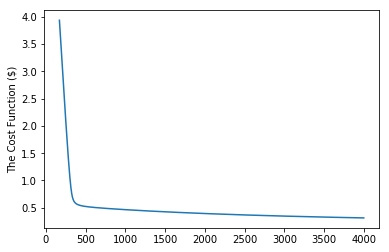

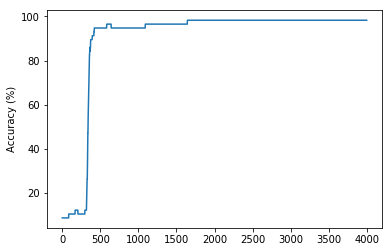

Accuracy: 98%


In [10]:
myModelParameters = Model(xTrain, yTrain, xTest, yTest, nNodes, nFeatures, 4000, debug, 0.001)

predictions = prediction(xTest, myModelParameters)

print ('Accuracy: %d' % float((np.dot(yTest, predictions.T) + np.dot(1 - yTest, 1 - predictions.T))
                              / float(yTest.size) * 100) + '%')
